## Easy way to work with unstructures grids

There are several ways to perform interpolation from unstructured to regular grid from command line tools like `cdo` to specialised python packages like [`pyfesom2`](https://github.com/FESOM/pyfesom2/). We will cover them in other chapters - here we show the way of how to interpolate unstructured grid data usual scientific python packages, that are most probably already available on your system.

In [1]:
import xarray as xr
import matplotlib.pylab as plt
import numpy as np
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator, NearestNDInterpolator
import scipy.spatial.qhull as qhull
import matplotlib.tri as mtri
%matplotlib inline
xr.set_options(display_style="text") # make it look better when posted online. Comment to get nicer representation of xarrays

Unstructured meshes look scary at first:

<img src="./images/fig_geometry.png" style="width: 800px;">

But for practical purposes you can have very simple high level conceptual image of the meshes, as scatter data, that have lon lat coordinates associated with each data point. We will develop it further, but let stick to this though for a while. To work with this data initially we need coordinates and some data.

In [2]:
data = xr.open_dataset('/work/bk1040/DYAMOND/.input_winter_data/IFS-FESOM2-4km/sst.fesom.2020.nc')

In [3]:
data

<xarray.Dataset>
Dimensions:  (nod2: 912469, time: 960)
Coordinates:
  * time     (time) datetime64[ns] 2020-01-20T00:40:00 ... 2020-02-28T23:40:00
Dimensions without coordinates: nod2
Data variables:
    sst      (time, nod2) float32 ...

The grid description, including coordinates of the data points are usually stored in a separate file.

In [4]:
grid = xr.open_dataset('/work/ab0995/a270046/fesom2-meshes/NEMO_ecmwf/NEMO/NEMO.grid.CDO.nc')

In [5]:
grid

<xarray.Dataset>
Dimensions:          (Three: 3, ncells: 912469, nlinks_max: 6, ntriags: 1801435, vertices: 12)
Coordinates:
    lon              (ncells) float64 ...
    lat              (ncells) float64 ...
Dimensions without coordinates: Three, ncells, nlinks_max, ntriags, vertices
Data variables:
    lon_bnds         (ncells, vertices) float64 ...
    lat_bnds         (ncells, vertices) float64 ...
    cell_area        (ncells) float64 ...
    node_node_links  (ncells, nlinks_max) float64 ...
    triag_nodes      (ntriags, Three) float64 ...
    coast            (ncells) float64 ...
Attributes:
    Conventions:  CF-1.4
    history:      Grid description file generated with spheRlab sl.grid.writeCDO

To simplify matters we create separate variables, that would contain coordinates and one time step of surface data data:

In [6]:
model_lon = grid.lon.values
model_lat = grid.lat.values
data_sample = data.sst[0,:].values

Very simple way to look at the data is to plot them as dots

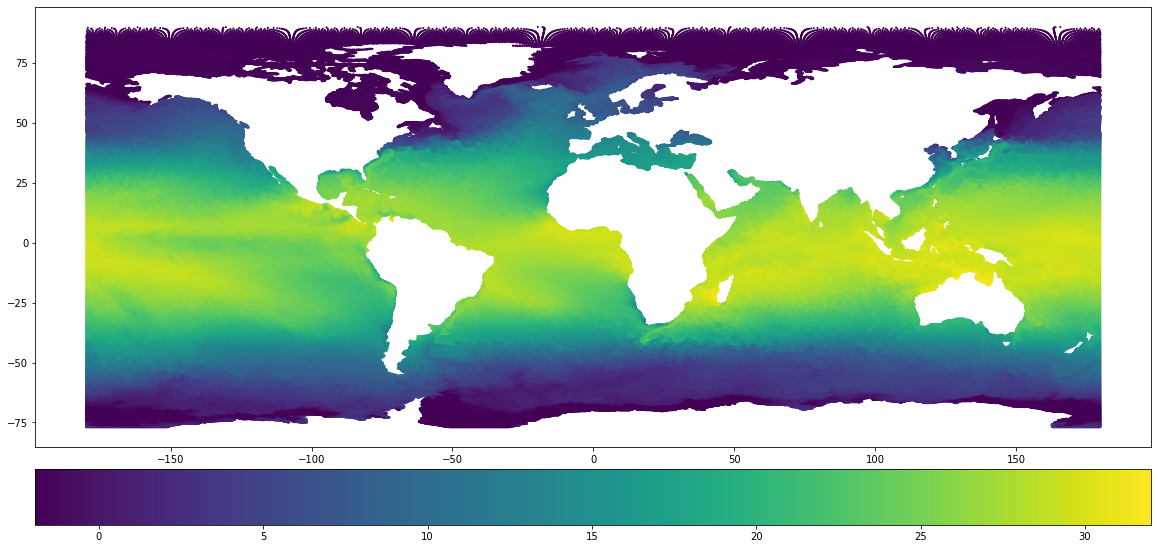

In [7]:
plt.figure(figsize=(20,10))
plt.scatter(model_lon, model_lat, s=1 , c=data_sample)
plt.colorbar(orientation='horizontal', pad=0.04)

Already with 1M points the plots are not extremelly fast, so one can use not every point:

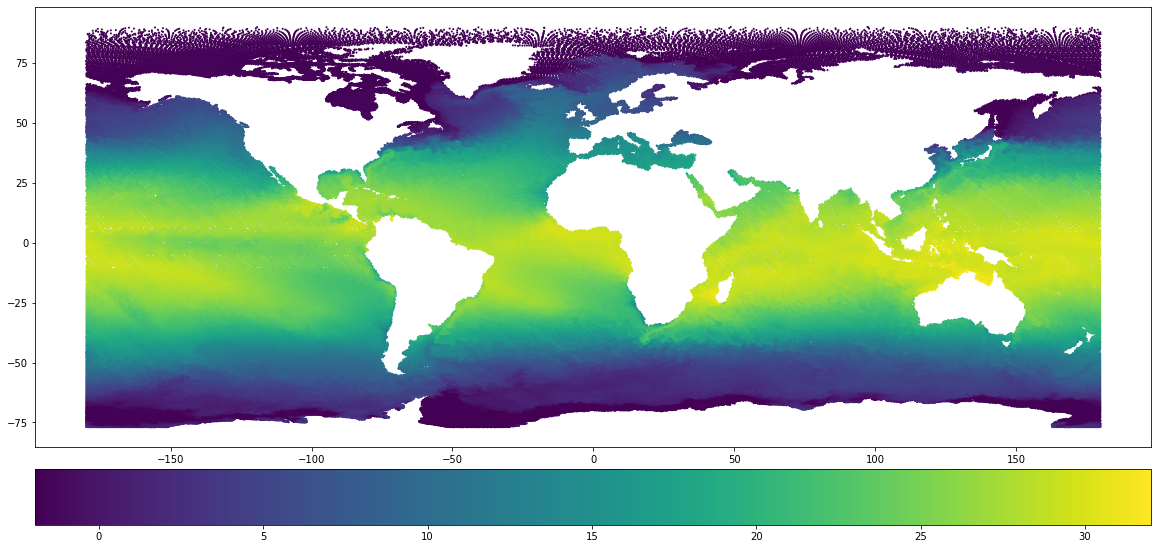

In [28]:
sstep = 3
plt.figure(figsize=(20,10))
plt.scatter(model_lon[::sstep], model_lat[::sstep], s=1 , c=data_sample[::sstep])
plt.colorbar(orientation='horizontal', pad=0.04)

## Cut the region

In [8]:
left = -80
right = -20
bottom = 20
top = 60

In [9]:
region = (model_lon < right) & (model_lon>left) & (model_lat > bottom) & (model_lat < top)

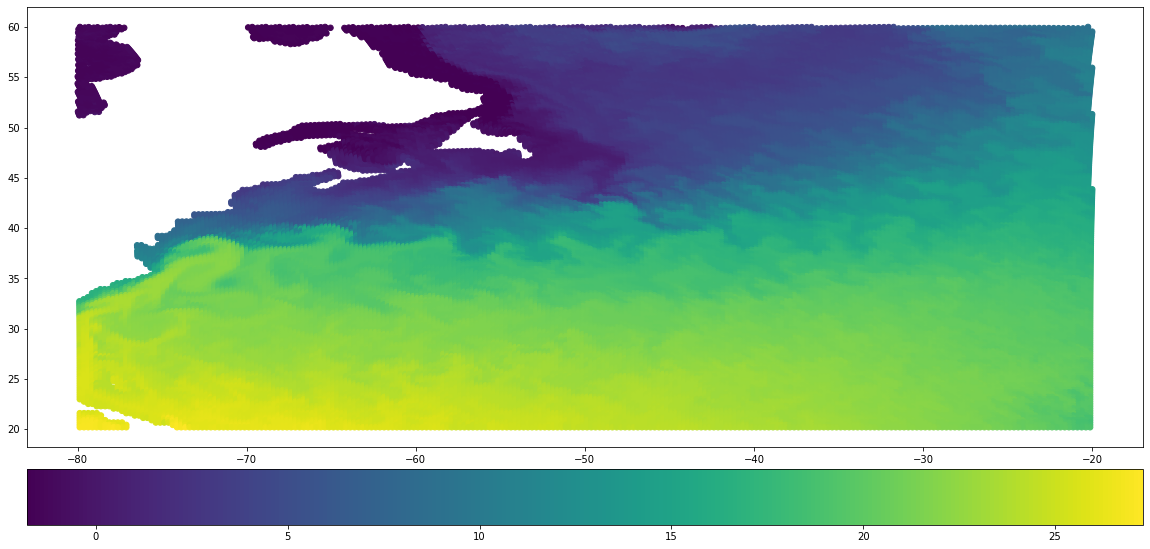

In [38]:
sstep = 1
plt.figure(figsize=(20,10))
plt.scatter(model_lon[region][::sstep], model_lat[region][::sstep], s=30 , c=data_sample[region][::sstep])
plt.colorbar(orientation='horizontal', pad=0.04)

## Simple scatter maps

If you lucky engout to have cartopy installed on your sustem, then you can even put this into a map.

In [30]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import cm

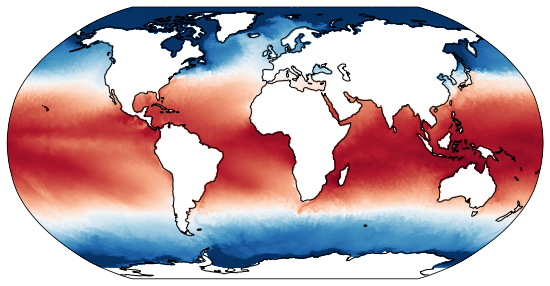

In [41]:
sstep = 3
plt.figure(figsize=(10,5))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines(resolution='110m', color='k')
ax.scatter(model_lon[::sstep], model_lat[::sstep], s=1 , c=data_sample[::sstep],
            cmap=cm.RdBu_r, transform=ccrs.PlateCarree())

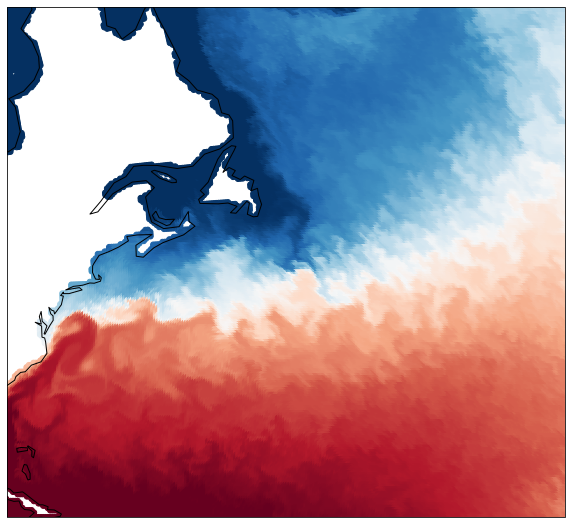

In [50]:
sstep = 1
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.Mercator())
ax.coastlines(resolution='110m', color='k')
ax.set_extent([left, right, bottom, top], crs=ccrs.PlateCarree())
ax.scatter(model_lon[::sstep], model_lat[::sstep], s=30 , c=data_sample[::sstep], 
           vmin=0, vmax=25,
           cmap=cm.RdBu_r, transform=ccrs.PlateCarree())

Looks not ideal, but if you whant to have something quick and dirty, this is the way.

## Simple interpolation to regular grid

The next step would be to get the data to regular grid, so that one can compre to observations, or do better plots.

Let's define a small region in the open ocean, that has no land. You need to generate 2D lat lon coordinates, so that for every point of our grid we have coordinates.

In [10]:
lon = np.linspace(-70, -60, 80)
lat = np.linspace(30, 40, 80)
lon2, lat2 = np.meshgrid(lon, lat)

For `scipy` interpolation functions we have to put coordinates in particularelly shaped array: 

In [11]:
points = np.vstack((model_lon, model_lat)).T
points

array([[-107.4304,   66.8853],
       [-107.3679,   66.9388],
       [-107.5654,   66.829 ],
       ...,
       [  72.625 ,   21.5941],
       [  72.375 ,   22.057 ],
       [  72.625 ,   21.8258]])

### nearest neighbor

The simples method of interpolation is nearest neighbor. First we have to generate interpolation function from coordinates (`points`) and data (`data_sample`)

In [12]:
%%time
nn_interpolation = NearestNDInterpolator(points, data_sample)

CPU times: user 348 ms, sys: 22 ms, total: 370 ms
Wall time: 365 ms


And now interpolate our data to another grid:

In [13]:
%%time
interpolated_nn = nn_interpolation((lon2, lat2))

CPU times: user 15 ms, sys: 3 ms, total: 18 ms
Wall time: 14.9 ms


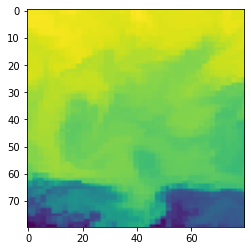

In [14]:
plt.imshow(interpolated_nn)

This method is relativelly fast, and it's ok to use for most of visualization purpoces. However there are other methods available:

### linear

Much slower, but should be more precise in many cases:

In [57]:
%%time
linear_interpolation = LinearNDInterpolator(points, data_sample)

CPU times: user 13.1 s, sys: 672 ms, total: 13.7 s
Wall time: 13.8 s


In [58]:
%%time
interpolated_ln = linear_interpolation((lon2, lat2))

CPU times: user 3.07 s, sys: 4 ms, total: 3.07 s
Wall time: 3.08 s


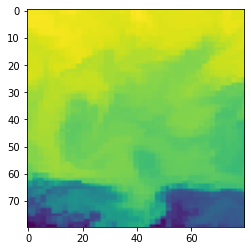

In [59]:
plt.imshow(interpolated_nn)

Difference to nearest neighbor:

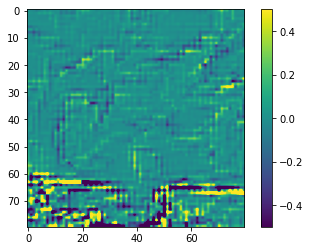

In [62]:
plt.imshow(interpolated_ln-interpolated_nn, vmin=-0.5, vmax=0.5)
plt.colorbar()

### bilinear

In [63]:
%%time
bilinear_interpolation = CloughTocher2DInterpolator(points, data_sample)

CPU times: user 15.6 s, sys: 139 ms, total: 15.8 s
Wall time: 15.8 s


In [64]:
%%time
interpolated_bln = linear_interpolation((lon2, lat2))

CPU times: user 5 ms, sys: 0 ns, total: 5 ms
Wall time: 2.94 ms


In this case there is no difference between linear and bilinear interpolations:

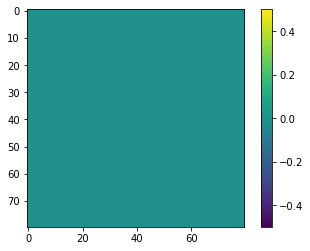

In [66]:
plt.imshow(interpolated_ln-interpolated_bln, vmin=-0.5, vmax=0.5)
plt.colorbar()

## Data with boundaries

If you data covering the whole globe (as in case of atmospheric models), your live is easy :) boundaries introduce a new level of complications, and it's hard to use standard methods of interpolation in their presence: 

In [15]:
lon = np.linspace(-100, -10, 90*4)
lat = np.linspace(-10, 30, 40*4)
lon2, lat2 = np.meshgrid(lon, lat)

In [16]:
%%time
nn_interpolation = NearestNDInterpolator(points, data_sample)
data_interpolated_global = nn_interpolation((lon2, lat2))

CPU times: user 424 ms, sys: 13 ms, total: 437 ms
Wall time: 432 ms


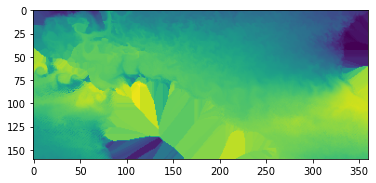

In [17]:
plt.imshow(np.flipud(data_interpolated_global))

To fix this we have to provide information about geometry of our cells (triangles in our case): 

In [18]:
elements = grid.triag_nodes.data.astype('int32') - 1

We substruct 1, since countinting in Fortran starts from 1, while in python from 0. 

In [19]:
elements

array([[670287, 669273, 670288],
       [670287, 670288, 671298],
       [671298, 670288, 671299],
       ...,
       [   226,    257,    224],
       [   257,    225,    224],
       [   224,    225,    197]], dtype=int32)

Each row in this array is a triangle, and each value in the row is the index of vertices, so that:

In [20]:
elements[0,:]

array([670287, 669273, 670288], dtype=int32)

In [21]:
model_lon[elements[0,:]]

array([72.875, 73.125, 73.125])

In [22]:
model_lat[elements[0,:]]

array([-69.1069, -69.1959, -69.1069])

Since tracer data in FESOM2 located on vertices of triangles, we can do this to get the values fro the first triangle:

In [23]:
data_sample[elements[0,:]]

array([4.926336 , 4.6483836, 4.987902 ], dtype=float32)

And the mean value for triangle will be:

In [24]:
data_sample[elements[0,:]].mean()

4.8542075

You should just have elements to create triangulation. Unfortunatelly elements that we get from FESOM2 are not ideal for plotting, since some of the triangles have coordinates like:

    [ 176.9465, -179.3587,  163.4757]
    
This triangle is close to +-180 meredian, and this is not valid for matplotlib triangulation (thinks that triangles are overlaping). The easiest way to deal with it is to remove triangles, that have this kind of points. Something you certainly don't want to do for computing integrals, but for most simple analysis and visualizations is fine.

We search for elements that have lon coordinates that differe by 100 degrees and return a list (`no_cyclic_elem`) of elements that don't have such elements.


In [25]:
d = model_lon[elements].max(axis=1) - model_lon[elements].min(axis=1)
no_cyclic_elem = np.argwhere(d < 100).ravel()

Here we create matplotlib triangulation, that consist of only non cyclic triangles:

In [26]:
triang = mtri.Triangulation(model_lon, model_lat, elements[no_cyclic_elem])

And here we create interpolator, and provide target coordinates for interpolation:

In [27]:
%%time
masked_data = mtri.LinearTriInterpolator(triang, data_sample)(lon2, lat2)

CPU times: user 16.6 s, sys: 882 ms, total: 17.5 s
Wall time: 17.4 s


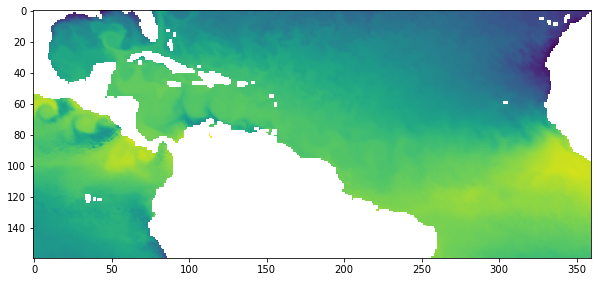

In [28]:
plt.figure(figsize=(10,10))
plt.imshow(np.flipud(masked_data))

This can be then easilly put on the map with cartopy:

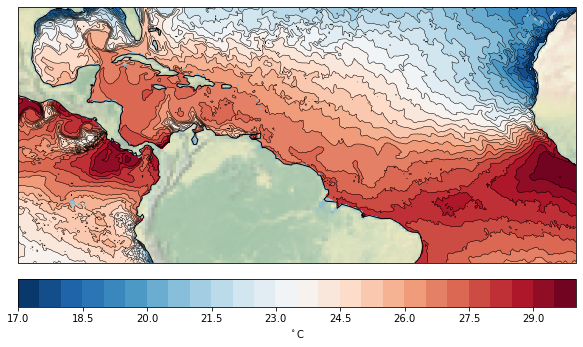

In [31]:
sstep = 1
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.Mercator())
ax.coastlines(resolution='110m', color='k')
# ax.set_extent([left, right, bottom, top], crs=ccrs.PlateCarree())
img = ax.contourf(lon, lat, masked_data, 
           levels = np.linspace(17,30,27),
           cmap=cm.RdBu_r, transform=ccrs.PlateCarree())
ax.contour(lon, lat, masked_data, 
           levels = np.linspace(17,30,27),
           transform=ccrs.PlateCarree(), zorder=10, colors='k', linewidths=0.5)
ax.stock_img()
cbar = plt.colorbar(img, orientation='horizontal', pad=0.03)
cbar.set_label('$^\circ$C')

### Faster interpolation with bining

The `LinearTriInterpolator` function first create `trifinder` that takes most of the time to compute. We can compute it separatelly and reuse. It returns an array with indexes of elements that contain target points. We can do very simple bining:

In [92]:
%%time
trifinder = mtri.TrapezoidMapTriFinder(triang)

CPU times: user 20 s, sys: 924 ms, total: 20.9 s
Wall time: 21 s


In [93]:
inter = trifinder(lon2, lat2)

In [94]:
inter

array([[ 979463,  980442,  981418, ..., 1481694, 1483316, 1484927],
       [ 979465,  980444,  981420, ..., 1481696, 1483318, 1484929],
       [ 979467,  980446,  981422, ..., 1481698, 1483320, 1484931],
       ...,
       [     -1,      -1,      -1, ..., 1481828, 1483447,      -1],
       [     -1,      -1,      -1, ..., 1481830, 1483449, 1485054],
       [     -1,      -1,      -1, ..., 1481832, 1483451, 1485056]],
      dtype=int32)

If target point do not belong to any triangle, the `-1` is returned. So we can look at this array and see there the land is:

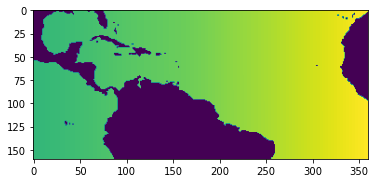

In [95]:
plt.imshow(np.flipud(inter))

Here we interpolate from nodes to elements, and select data only from elements we interested in:

In [96]:
data_on_elements = data_sample[elements[no_cyclic_elem]].mean(axis=1)
binned_data = data_on_elements[inter]

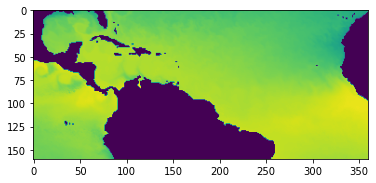

In [97]:
plt.imshow(np.flipud(binned_data))

Create mask for valies over land:

In [39]:
m,n = np.where(inter==-1)

And apply the mask:

In [40]:
binned_data[m,n] = np.nan

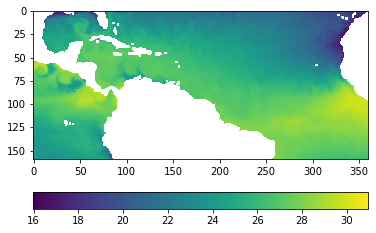

In [41]:
plt.imshow(np.flipud(binned_data))
plt.colorbar(orientation='horizontal')

This is the fastest way to do "boundary aware" interpolation, which is espetially useful, when you have large amounts of data.

### Interpolate to grid from observations

Uncomment to download the data ([Source](https://psl.noaa.gov/data/gridded/data.cobe.html))

In [42]:
# !wget ftp://ftp.cdc.noaa.gov/Datasets/COBE/sst.mon.mean.nc

In [43]:
obs_file = xr.open_dataset('./sst.mon.mean.nc')

In [44]:
obs_file

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 1568)
Coordinates:
  * lat      (lat) float32 89.5 88.5 87.5 86.5 85.5 ... -86.5 -87.5 -88.5 -89.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time     (time) datetime64[ns] 1891-01-01 1891-02-01 ... 2021-08-01
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes:
    title:            COBE Sea Surface Temperature Analysis
    history:          created June 2011 at ESRL/PSD using the grib data from ...
    platform:         Analyses
    original_source:  http://near-goos1.jodc.go.jp/cgi-bin/1997/near_goos_cat...
    Conventions:      CF-1.2
    institution:      NOAA ESRL/PSD
    comment:          recent values (w/i last year) may change as dataset is ...
    dataset_title:    COBE Sea Surface Temperature
    References:       https://www.psl.noaa.gov/data/gridded/data.cobe.html

In [45]:
lon_sst = obs_file.lon.data
lat_sst = obs_file.lat.data

In [46]:
lon_sst_mod = np.where(lon_sst>180, lon_sst-360, lon_sst)

In [47]:
lon_sst2, lat_sst2 = np.meshgrid(lon_sst_mod, lat_sst)

In [48]:
lon_sst2

array([[ 0.5,  1.5,  2.5, ..., -2.5, -1.5, -0.5],
       [ 0.5,  1.5,  2.5, ..., -2.5, -1.5, -0.5],
       [ 0.5,  1.5,  2.5, ..., -2.5, -1.5, -0.5],
       ...,
       [ 0.5,  1.5,  2.5, ..., -2.5, -1.5, -0.5],
       [ 0.5,  1.5,  2.5, ..., -2.5, -1.5, -0.5],
       [ 0.5,  1.5,  2.5, ..., -2.5, -1.5, -0.5]], dtype=float32)

In [49]:
fesom_on_obs_grid = mtri.LinearTriInterpolator(triang, data_sample)(lon_sst2, lat_sst2)

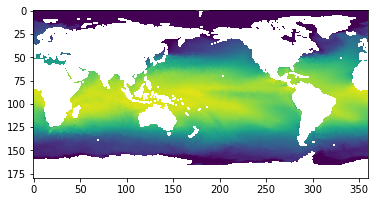

In [50]:
plt.imshow(fesom_on_obs_grid)

In [51]:
obs_sample = obs_file.sst.sel(time='2020-01').data[0,:,:]

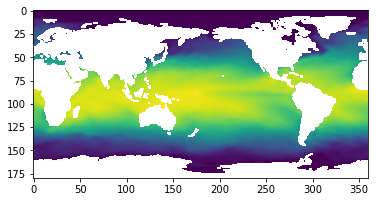

In [52]:
plt.imshow(obs_sample)

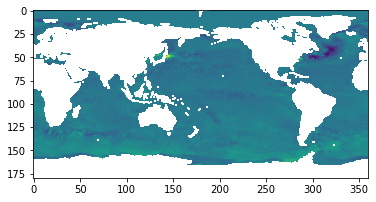

In [53]:
plt.imshow(fesom_on_obs_grid-obs_sample)

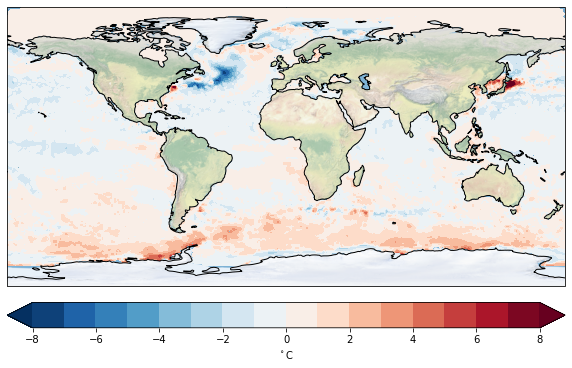

In [54]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='110m', color='k')
img = ax.contourf(lon_sst, lat_sst, fesom_on_obs_grid-obs_sample, 
           levels = np.linspace(-8,8,17),
           cmap=cm.RdBu_r, transform=ccrs.PlateCarree(), extend='both')
ax.stock_img()
cbar = plt.colorbar(img, orientation='horizontal', pad=0.03)
cbar.set_label('$^\circ$C')

## Working with deeper layers

All data points at FESOM2 surface layer are valid, but when you go deeper, some of the points naturally become invalis, since they "hit" the bottom. So if you would like to properlly plot data at depth, you should take into account, that missing values should be properly processed.

In [86]:
data3D = xr.open_dataset('/work/bk1040/DYAMOND/.input_winter_data/IFS-FESOM2-4km/temp.fesom.2020.nc')

In [87]:
data3D

<xarray.Dataset>
Dimensions:  (nod2: 912469, nz1: 47, time: 320)
Coordinates:
  * time     (time) datetime64[ns] 2020-01-20T02:40:00 ... 2020-02-28T23:40:00
Dimensions without coordinates: nod2, nz1
Data variables:
    temp     (time, nod2, nz1) float32 ...

We take one field from 3000 meters

In [88]:
data_at_3000_m = data3D.temp[0,:,35].data

Missing values are 0:

In [89]:
data_at_3000_m

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

### Naive aproach:

Just for demonstration, here is what happens if you interpolate considering all triangles: 

In [90]:
bad_interpolation = mtri.LinearTriInterpolator(triang, data_at_3000_m)(lon2, lat2)

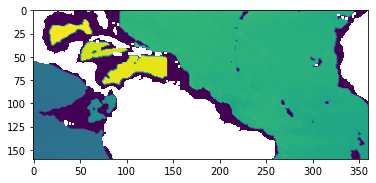

In [91]:
plt.imshow(np.flipud(bad_interpolation))

### Better way

We have to tell matplotlib to ignore the triangles with 0 values. To do this we first have to interpolate our data to elements, select triangles with 0 values and create mask out of them:

In [75]:
data_at_3000_m_on_elements = data_at_3000_m[elements[no_cyclic_elem]].mean(axis=1)

In [76]:
data_at_3000_m_on_elements[data_at_3000_m_on_elements==0] = -999

In [77]:
mmask = data_at_3000_m_on_elements==-999

Now we can use this mask in order to do new, masked triangulation:

In [78]:
triang2 = mtri.Triangulation(model_lon, model_lat, elements[no_cyclic_elem], mask=mmask)

As you can see total number of triangles and the number of non masked are different:

In [79]:
triang2.get_masked_triangles().shape

(1799476, 3)

In [80]:
triang2.triangles.shape

(1799476, 3)

We should also mask the invalid data themselves:

In [81]:
data_at_3000_m[data_at_3000_m==0] = np.nan

In [82]:
data_at_3000_m

array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)

And now we are ready to do the interpolation with masked triangulation and masked data:

In [83]:
good_interpolation = mtri.LinearTriInterpolator(triang2, data_at_3000_m)(lon2, lat2)

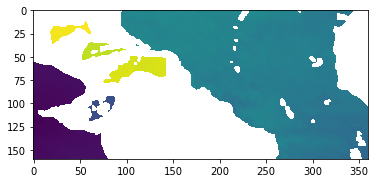

In [84]:
plt.imshow(np.flipud(good_interpolation))

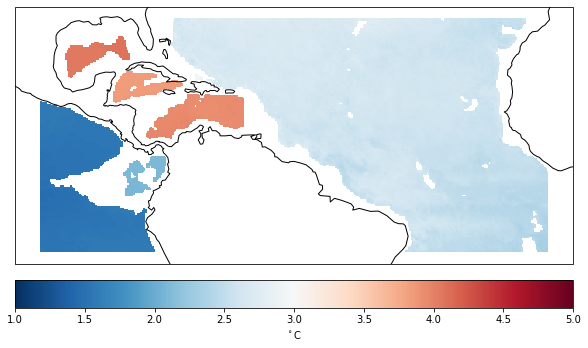

In [85]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.Mercator())
ax.coastlines(resolution='110m', color='k')
# ax.set_extent([left, right, bottom, top], crs=ccrs.PlateCarree())
img = ax.pcolormesh(lon, lat, good_interpolation, 
#            levels = np.linspace(2,5,27),
                    vmin=1, vmax=5,
           cmap=cm.RdBu_r, transform=ccrs.PlateCarree())
# ax.stock_img()
cbar = plt.colorbar(img, orientation='horizontal', pad=0.03)
cbar.set_label('$^\circ$C')